In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'elu',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

elu_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_b25_t1_mask_t1t2_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 920)
(734160, 1)
validation
(101248, 920)
(101248, 1)
test
(100432, 920)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 920)]             0         


 dense (Dense)               (None, 1024)              943104    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1632257 (6.23 MB)


Trainable params: 1632257 (6.23 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:24 - loss: 0.0742 - STD: 0.0319 - MAE: 0.2575

 5/74 [=>............................] - ETA: 1s - loss: 0.0541 - STD: 0.0064 - MAE: 0.2113  

 9/74 [==>...........................] - ETA: 1s - loss: 0.0520 - STD: 0.0035 - MAE: 0.2064

12/74 [===>..........................] - ETA: 1s - loss: 0.0512 - STD: 0.0027 - MAE: 0.2047

15/74 [=====>........................] - ETA: 1s - loss: 0.0508 - STD: 0.0021 - MAE: 0.2036

18/74 [======>.......................] - ETA: 2s - loss: 0.0505 - STD: 0.0018 - MAE: 0.2028

21/74 [=======>......................] - ETA: 2s - loss: 0.0503 - STD: 0.0015 - MAE: 0.2024

25/74 [=========>....................] - ETA: 1s - loss: 0.0501 - STD: 0.0013 - MAE: 0.2019

29/74 [==========>...................] - ETA: 1s - loss: 0.0499 - STD: 0.0011 - MAE: 0.2017

32/74 [===========>..................] - ETA: 1s - loss: 0.0499 - STD: 9.9584e-04 - MAE: 0.2015

35/74 [=============>................] - ETA: 1s - loss: 0.0499 - STD: 9.1048e-04 - MAE: 0.2015

39/74 [==============>...............] - ETA: 1s - loss: 0.0498 - STD: 8.1710e-04 - MAE: 0.2014

43/74 [================>.............] - ETA: 0s - loss: 0.0498 - STD: 7.4109e-04 - MAE: 0.2012

46/74 [=================>............] - ETA: 0s - loss: 0.0497 - STD: 6.9276e-04 - MAE: 0.2012

49/74 [==================>...........] - ETA: 0s - loss: 0.0497 - STD: 6.5035e-04 - MAE: 0.2010

52/74 [====================>.........] - ETA: 0s - loss: 0.0496 - STD: 6.1283e-04 - MAE: 0.2010

55/74 [=====================>........] - ETA: 0s - loss: 0.0496 - STD: 5.7940e-04 - MAE: 0.2009

58/74 [======================>.......] - ETA: 0s - loss: 0.0496 - STD: 5.4943e-04 - MAE: 0.2009

61/74 [=======================>......] - ETA: 0s - loss: 0.0496 - STD: 5.2241e-04 - MAE: 0.2009

64/74 [========================>.....] - ETA: 0s - loss: 0.0496 - STD: 4.9792e-04 - MAE: 0.2009

67/74 [==========================>...] - ETA: 0s - loss: 0.0496 - STD: 4.7563e-04 - MAE: 0.2008

70/74 [===========================>..] - ETA: 0s - loss: 0.0496 - STD: 4.5524e-04 - MAE: 0.2008

73/74 [============================>.] - ETA: 0s - loss: 0.0496 - STD: 4.3653e-04 - MAE: 0.2008

74/74 [==============================] - 4s 33ms/step - loss: 0.0496 - STD: 4.3063e-04 - MAE: 0.2007 - val_loss: 0.0481 - val_STD: 4.9546e-18 - val_MAE: 0.2017


Epoch 2/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0491 - STD: 9.1807e-18 - MAE: 0.1998

 4/74 [>.............................] - ETA: 1s - loss: 0.0494 - STD: 8.8604e-18 - MAE: 0.2005

 7/74 [=>............................] - ETA: 1s - loss: 0.0494 - STD: 8.9440e-18 - MAE: 0.2004

10/74 [===>..........................] - ETA: 1s - loss: 0.0493 - STD: 9.0253e-18 - MAE: 0.2001

13/74 [====>.........................] - ETA: 1s - loss: 0.0493 - STD: 9.0186e-18 - MAE: 0.2001

16/74 [=====>........................] - ETA: 1s - loss: 0.0494 - STD: 8.9569e-18 - MAE: 0.2003

19/74 [======>.......................] - ETA: 1s - loss: 0.0493 - STD: 8.8695e-18 - MAE: 0.2002

22/74 [=======>......................] - ETA: 0s - loss: 0.0494 - STD: 8.8701e-18 - MAE: 0.2003

25/74 [=========>....................] - ETA: 0s - loss: 0.0493 - STD: 8.8948e-18 - MAE: 0.2002

28/74 [==========>...................] - ETA: 0s - loss: 0.0493 - STD: 8.9183e-18 - MAE: 0.2001

31/74 [===========>..................] - ETA: 0s - loss: 0.0492 - STD: 8.8764e-18 - MAE: 0.2000

34/74 [============>.................] - ETA: 0s - loss: 0.0492 - STD: 8.8418e-18 - MAE: 0.2000

37/74 [==============>...............] - ETA: 0s - loss: 0.0492 - STD: 8.8536e-18 - MAE: 0.2001

40/74 [===============>..............] - ETA: 0s - loss: 0.0492 - STD: 8.8684e-18 - MAE: 0.2000

43/74 [================>.............] - ETA: 0s - loss: 0.0492 - STD: 8.8768e-18 - MAE: 0.2000

46/74 [=================>............] - ETA: 0s - loss: 0.0492 - STD: 8.8324e-18 - MAE: 0.2000

49/74 [==================>...........] - ETA: 0s - loss: 0.0492 - STD: 8.8142e-18 - MAE: 0.2000

52/74 [====================>.........] - ETA: 0s - loss: 0.0493 - STD: 8.8001e-18 - MAE: 0.2001

56/74 [=====================>........] - ETA: 0s - loss: 0.0493 - STD: 8.7908e-18 - MAE: 0.2001

59/74 [======================>.......] - ETA: 0s - loss: 0.0493 - STD: 8.7983e-18 - MAE: 0.2001

62/74 [========================>.....] - ETA: 0s - loss: 0.0492 - STD: 8.8129e-18 - MAE: 0.2000

64/74 [========================>.....] - ETA: 0s - loss: 0.0492 - STD: 8.7973e-18 - MAE: 0.2000

67/74 [==========================>...] - ETA: 0s - loss: 0.0492 - STD: 8.7951e-18 - MAE: 0.2000

70/74 [===========================>..] - ETA: 0s - loss: 0.0492 - STD: 8.7912e-18 - MAE: 0.2000

73/74 [============================>.] - ETA: 0s - loss: 0.0492 - STD: 8.7953e-18 - MAE: 0.2000

74/74 [==============================] - 2s 22ms/step - loss: 0.0492 - STD: 8.7967e-18 - MAE: 0.2000 - val_loss: 0.0481 - val_STD: 4.8638e-18 - val_MAE: 0.2017


Epoch 3/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0493 - STD: 9.0307e-18 - MAE: 0.2001

 4/74 [>.............................] - ETA: 1s - loss: 0.0494 - STD: 8.9201e-18 - MAE: 0.2004

 7/74 [=>............................] - ETA: 1s - loss: 0.0495 - STD: 9.0241e-18 - MAE: 0.2006

10/74 [===>..........................] - ETA: 1s - loss: 0.0495 - STD: 8.8914e-18 - MAE: 0.2005

13/74 [====>.........................] - ETA: 1s - loss: 0.0493 - STD: 8.8768e-18 - MAE: 0.2002

16/74 [=====>........................] - ETA: 1s - loss: 0.0492 - STD: 8.8429e-18 - MAE: 0.2000

19/74 [======>.......................] - ETA: 1s - loss: 0.0492 - STD: 8.8080e-18 - MAE: 0.2001

22/74 [=======>......................] - ETA: 0s - loss: 0.0493 - STD: 8.8034e-18 - MAE: 0.2001

25/74 [=========>....................] - ETA: 0s - loss: 0.0492 - STD: 8.7536e-18 - MAE: 0.2000

28/74 [==========>...................] - ETA: 0s - loss: 0.0492 - STD: 8.7272e-18 - MAE: 0.2000

31/74 [===========>..................] - ETA: 0s - loss: 0.0493 - STD: 8.6984e-18 - MAE: 0.2001

34/74 [============>.................] - ETA: 0s - loss: 0.0492 - STD: 8.6946e-18 - MAE: 0.2000

38/74 [==============>...............] - ETA: 0s - loss: 0.0492 - STD: 8.6812e-18 - MAE: 0.2000

41/74 [===============>..............] - ETA: 0s - loss: 0.0492 - STD: 8.7040e-18 - MAE: 0.1999

44/74 [================>.............] - ETA: 0s - loss: 0.0492 - STD: 8.7038e-18 - MAE: 0.1999

47/74 [==================>...........] - ETA: 0s - loss: 0.0492 - STD: 8.7102e-18 - MAE: 0.1999

50/74 [===================>..........] - ETA: 0s - loss: 0.0492 - STD: 8.7159e-18 - MAE: 0.2000

53/74 [====================>.........] - ETA: 0s - loss: 0.0492 - STD: 8.7206e-18 - MAE: 0.2000

56/74 [=====================>........] - ETA: 0s - loss: 0.0492 - STD: 8.6979e-18 - MAE: 0.2000

59/74 [======================>.......] - ETA: 0s - loss: 0.0492 - STD: 8.7119e-18 - MAE: 0.2000

62/74 [========================>.....] - ETA: 0s - loss: 0.0492 - STD: 8.7272e-18 - MAE: 0.2000

65/74 [=========================>....] - ETA: 0s - loss: 0.0492 - STD: 8.7426e-18 - MAE: 0.2000

68/74 [==========================>...] - ETA: 0s - loss: 0.0492 - STD: 8.7584e-18 - MAE: 0.2000

71/74 [===========================>..] - ETA: 0s - loss: 0.0492 - STD: 8.7510e-18 - MAE: 0.2000

74/74 [==============================] - ETA: 0s - loss: 0.0492 - STD: 8.7695e-18 - MAE: 0.2000

74/74 [==============================] - 2s 21ms/step - loss: 0.0492 - STD: 8.7695e-18 - MAE: 0.2000 - val_loss: 0.0481 - val_STD: 4.8638e-18 - val_MAE: 0.2017


Epoch 4/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0483 - STD: 8.3916e-18 - MAE: 0.1979

 4/74 [>.............................] - ETA: 1s - loss: 0.0490 - STD: 8.8225e-18 - MAE: 0.1996

 7/74 [=>............................] - ETA: 1s - loss: 0.0489 - STD: 8.9451e-18 - MAE: 0.1995

10/74 [===>..........................] - ETA: 1s - loss: 0.0493 - STD: 8.7864e-18 - MAE: 0.2002

13/74 [====>.........................] - ETA: 1s - loss: 0.0492 - STD: 8.7534e-18 - MAE: 0.2000

16/74 [=====>........................] - ETA: 1s - loss: 0.0492 - STD: 8.7017e-18 - MAE: 0.1999

19/74 [======>.......................] - ETA: 1s - loss: 0.0492 - STD: 8.7291e-18 - MAE: 0.2000

22/74 [=======>......................] - ETA: 0s - loss: 0.0492 - STD: 8.7282e-18 - MAE: 0.2000

25/74 [=========>....................] - ETA: 0s - loss: 0.0492 - STD: 8.7072e-18 - MAE: 0.1999

28/74 [==========>...................] - ETA: 0s - loss: 0.0492 - STD: 8.7433e-18 - MAE: 0.1999

31/74 [===========>..................] - ETA: 0s - loss: 0.0492 - STD: 8.7527e-18 - MAE: 0.2000

34/74 [============>.................] - ETA: 0s - loss: 0.0492 - STD: 8.7847e-18 - MAE: 0.1999

37/74 [==============>...............] - ETA: 0s - loss: 0.0492 - STD: 8.7960e-18 - MAE: 0.1999

40/74 [===============>..............] - ETA: 0s - loss: 0.0492 - STD: 8.7833e-18 - MAE: 0.1999

43/74 [================>.............] - ETA: 0s - loss: 0.0491 - STD: 8.7731e-18 - MAE: 0.1998

46/74 [=================>............] - ETA: 0s - loss: 0.0491 - STD: 8.7603e-18 - MAE: 0.1999

49/74 [==================>...........] - ETA: 0s - loss: 0.0491 - STD: 8.7535e-18 - MAE: 0.1999

52/74 [====================>.........] - ETA: 0s - loss: 0.0492 - STD: 8.7569e-18 - MAE: 0.1999

55/74 [=====================>........] - ETA: 0s - loss: 0.0491 - STD: 8.7445e-18 - MAE: 0.1999

58/74 [======================>.......] - ETA: 0s - loss: 0.0491 - STD: 8.7423e-18 - MAE: 0.1998

61/74 [=======================>......] - ETA: 0s - loss: 0.0492 - STD: 8.7558e-18 - MAE: 0.1999

64/74 [========================>.....] - ETA: 0s - loss: 0.0492 - STD: 8.7572e-18 - MAE: 0.1999

67/74 [==========================>...] - ETA: 0s - loss: 0.0492 - STD: 8.7622e-18 - MAE: 0.2000

70/74 [===========================>..] - ETA: 0s - loss: 0.0492 - STD: 8.7535e-18 - MAE: 0.2000

74/74 [==============================] - ETA: 0s - loss: 0.0492 - STD: 8.7733e-18 - MAE: 0.2000

74/74 [==============================] - 2s 22ms/step - loss: 0.0492 - STD: 8.7733e-18 - MAE: 0.2000 - val_loss: 0.0481 - val_STD: 4.8638e-18 - val_MAE: 0.2017


Epoch 5/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0495 - STD: 8.1801e-18 - MAE: 0.2007

 4/74 [>.............................] - ETA: 1s - loss: 0.0491 - STD: 8.6050e-18 - MAE: 0.1999

 7/74 [=>............................] - ETA: 1s - loss: 0.0491 - STD: 8.7791e-18 - MAE: 0.1999

10/74 [===>..........................] - ETA: 1s - loss: 0.0491 - STD: 8.7605e-18 - MAE: 0.1998

13/74 [====>.........................] - ETA: 1s - loss: 0.0492 - STD: 8.8503e-18 - MAE: 0.2000

16/74 [=====>........................] - ETA: 1s - loss: 0.0493 - STD: 8.8010e-18 - MAE: 0.2001

19/74 [======>.......................] - ETA: 1s - loss: 0.0492 - STD: 8.8148e-18 - MAE: 0.2001

22/74 [=======>......................] - ETA: 0s - loss: 0.0492 - STD: 8.8024e-18 - MAE: 0.2001

26/74 [=========>....................] - ETA: 0s - loss: 0.0492 - STD: 8.7801e-18 - MAE: 0.2000

29/74 [==========>...................] - ETA: 0s - loss: 0.0492 - STD: 8.7399e-18 - MAE: 0.1999

32/74 [===========>..................] - ETA: 0s - loss: 0.0492 - STD: 8.7324e-18 - MAE: 0.1999

35/74 [=============>................] - ETA: 0s - loss: 0.0492 - STD: 8.7422e-18 - MAE: 0.2000

38/74 [==============>...............] - ETA: 0s - loss: 0.0492 - STD: 8.7407e-18 - MAE: 0.2000

41/74 [===============>..............] - ETA: 0s - loss: 0.0492 - STD: 8.7660e-18 - MAE: 0.2000

44/74 [================>.............] - ETA: 0s - loss: 0.0492 - STD: 8.7774e-18 - MAE: 0.2000

47/74 [==================>...........] - ETA: 0s - loss: 0.0492 - STD: 8.7782e-18 - MAE: 0.2000

50/74 [===================>..........] - ETA: 0s - loss: 0.0492 - STD: 8.7691e-18 - MAE: 0.2000

53/74 [====================>.........] - ETA: 0s - loss: 0.0492 - STD: 8.7747e-18 - MAE: 0.2000

56/74 [=====================>........] - ETA: 0s - loss: 0.0492 - STD: 8.7758e-18 - MAE: 0.2000

59/74 [======================>.......] - ETA: 0s - loss: 0.0492 - STD: 8.7706e-18 - MAE: 0.2000

62/74 [========================>.....] - ETA: 0s - loss: 0.0492 - STD: 8.7789e-18 - MAE: 0.1999

65/74 [=========================>....] - ETA: 0s - loss: 0.0492 - STD: 8.7839e-18 - MAE: 0.2000

68/74 [==========================>...] - ETA: 0s - loss: 0.0492 - STD: 8.7755e-18 - MAE: 0.2000

71/74 [===========================>..] - ETA: 0s - loss: 0.0492 - STD: 8.7823e-18 - MAE: 0.2000

74/74 [==============================] - ETA: 0s - loss: 0.0492 - STD: 8.7777e-18 - MAE: 0.2000

74/74 [==============================] - 2s 22ms/step - loss: 0.0492 - STD: 8.7777e-18 - MAE: 0.2000 - val_loss: 0.0481 - val_STD: 4.8638e-18 - val_MAE: 0.2017


Epoch 6/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0484 - STD: 8.7321e-18 - MAE: 0.1983

 4/74 [>.............................] - ETA: 1s - loss: 0.0491 - STD: 8.9656e-18 - MAE: 0.1997

 8/74 [==>...........................] - ETA: 1s - loss: 0.0490 - STD: 8.8379e-18 - MAE: 0.1996

11/74 [===>..........................] - ETA: 1s - loss: 0.0493 - STD: 8.8695e-18 - MAE: 0.2001

14/74 [====>.........................] - ETA: 1s - loss: 0.0493 - STD: 8.9180e-18 - MAE: 0.2001

17/74 [=====>........................] - ETA: 1s - loss: 0.0492 - STD: 8.8477e-18 - MAE: 0.2000

20/74 [=======>......................] - ETA: 0s - loss: 0.0493 - STD: 8.7598e-18 - MAE: 0.2001

23/74 [========>.....................] - ETA: 0s - loss: 0.0493 - STD: 8.7925e-18 - MAE: 0.2002

26/74 [=========>....................] - ETA: 0s - loss: 0.0493 - STD: 8.8126e-18 - MAE: 0.2001

29/74 [==========>...................] - ETA: 0s - loss: 0.0493 - STD: 8.7898e-18 - MAE: 0.2001

32/74 [===========>..................] - ETA: 0s - loss: 0.0493 - STD: 8.8328e-18 - MAE: 0.2001

35/74 [=============>................] - ETA: 0s - loss: 0.0493 - STD: 8.8127e-18 - MAE: 0.2000

38/74 [==============>...............] - ETA: 0s - loss: 0.0493 - STD: 8.8215e-18 - MAE: 0.2000

41/74 [===============>..............] - ETA: 0s - loss: 0.0492 - STD: 8.8062e-18 - MAE: 0.2000

44/74 [================>.............] - ETA: 0s - loss: 0.0492 - STD: 8.7917e-18 - MAE: 0.2000

47/74 [==================>...........] - ETA: 0s - loss: 0.0493 - STD: 8.8053e-18 - MAE: 0.2000

50/74 [===================>..........] - ETA: 0s - loss: 0.0493 - STD: 8.8156e-18 - MAE: 0.2000

53/74 [====================>.........] - ETA: 0s - loss: 0.0492 - STD: 8.7938e-18 - MAE: 0.2000

56/74 [=====================>........] - ETA: 0s - loss: 0.0492 - STD: 8.7981e-18 - MAE: 0.2000

59/74 [======================>.......] - ETA: 0s - loss: 0.0492 - STD: 8.7936e-18 - MAE: 0.2000

62/74 [========================>.....] - ETA: 0s - loss: 0.0492 - STD: 8.7937e-18 - MAE: 0.2000

65/74 [=========================>....] - ETA: 0s - loss: 0.0492 - STD: 8.7809e-18 - MAE: 0.2000

68/74 [==========================>...] - ETA: 0s - loss: 0.0492 - STD: 8.7666e-18 - MAE: 0.2000

71/74 [===========================>..] - ETA: 0s - loss: 0.0492 - STD: 8.7704e-18 - MAE: 0.2000

74/74 [==============================] - ETA: 0s - loss: 0.0492 - STD: 8.7714e-18 - MAE: 0.2000

74/74 [==============================] - 2s 22ms/step - loss: 0.0492 - STD: 8.7714e-18 - MAE: 0.2000 - val_loss: 0.0481 - val_STD: 4.8638e-18 - val_MAE: 0.2017


Epoch 7/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0486 - STD: 8.5471e-18 - MAE: 0.1984

 5/74 [=>............................] - ETA: 1s - loss: 0.0490 - STD: 8.8600e-18 - MAE: 0.1993

 8/74 [==>...........................] - ETA: 1s - loss: 0.0490 - STD: 8.8685e-18 - MAE: 0.1994

11/74 [===>..........................] - ETA: 1s - loss: 0.0491 - STD: 8.8652e-18 - MAE: 0.1996

14/74 [====>.........................] - ETA: 1s - loss: 0.0490 - STD: 8.8779e-18 - MAE: 0.1995

17/74 [=====>........................] - ETA: 1s - loss: 0.0491 - STD: 8.8145e-18 - MAE: 0.1996

20/74 [=======>......................] - ETA: 0s - loss: 0.0491 - STD: 8.8526e-18 - MAE: 0.1997

23/74 [========>.....................] - ETA: 0s - loss: 0.0492 - STD: 8.8465e-18 - MAE: 0.1998

26/74 [=========>....................] - ETA: 0s - loss: 0.0491 - STD: 8.8069e-18 - MAE: 0.1998

29/74 [==========>...................] - ETA: 0s - loss: 0.0492 - STD: 8.7820e-18 - MAE: 0.1998

32/74 [===========>..................] - ETA: 0s - loss: 0.0492 - STD: 8.7669e-18 - MAE: 0.1999

35/74 [=============>................] - ETA: 0s - loss: 0.0492 - STD: 8.7921e-18 - MAE: 0.1999

38/74 [==============>...............] - ETA: 0s - loss: 0.0492 - STD: 8.7880e-18 - MAE: 0.1999

41/74 [===============>..............] - ETA: 0s - loss: 0.0492 - STD: 8.7947e-18 - MAE: 0.1999

44/74 [================>.............] - ETA: 0s - loss: 0.0492 - STD: 8.7725e-18 - MAE: 0.2000

47/74 [==================>...........] - ETA: 0s - loss: 0.0492 - STD: 8.7836e-18 - MAE: 0.2000

50/74 [===================>..........] - ETA: 0s - loss: 0.0492 - STD: 8.8029e-18 - MAE: 0.1999

53/74 [====================>.........] - ETA: 0s - loss: 0.0492 - STD: 8.8067e-18 - MAE: 0.1999

56/74 [=====================>........] - ETA: 0s - loss: 0.0492 - STD: 8.7949e-18 - MAE: 0.2000

59/74 [======================>.......] - ETA: 0s - loss: 0.0492 - STD: 8.7791e-18 - MAE: 0.2000

62/74 [========================>.....] - ETA: 0s - loss: 0.0492 - STD: 8.7790e-18 - MAE: 0.2000

65/74 [=========================>....] - ETA: 0s - loss: 0.0492 - STD: 8.7813e-18 - MAE: 0.2000

68/74 [==========================>...] - ETA: 0s - loss: 0.0492 - STD: 8.7767e-18 - MAE: 0.2000

71/74 [===========================>..] - ETA: 0s - loss: 0.0492 - STD: 8.7844e-18 - MAE: 0.2000

74/74 [==============================] - ETA: 0s - loss: 0.0492 - STD: 8.7839e-18 - MAE: 0.2000

74/74 [==============================] - 2s 21ms/step - loss: 0.0492 - STD: 8.7839e-18 - MAE: 0.2000 - val_loss: 0.0481 - val_STD: 4.8638e-18 - val_MAE: 0.2017


Epoch 8/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0489 - STD: 8.4601e-18 - MAE: 0.1992

 4/74 [>.............................] - ETA: 1s - loss: 0.0494 - STD: 8.4361e-18 - MAE: 0.2004

 7/74 [=>............................] - ETA: 1s - loss: 0.0492 - STD: 8.7062e-18 - MAE: 0.1999

10/74 [===>..........................] - ETA: 1s - loss: 0.0493 - STD: 8.7079e-18 - MAE: 0.2001

13/74 [====>.........................] - ETA: 1s - loss: 0.0493 - STD: 8.7458e-18 - MAE: 0.2003

16/74 [=====>........................] - ETA: 1s - loss: 0.0492 - STD: 8.7647e-18 - MAE: 0.2000

19/74 [======>.......................] - ETA: 1s - loss: 0.0492 - STD: 8.7550e-18 - MAE: 0.2000

22/74 [=======>......................] - ETA: 0s - loss: 0.0492 - STD: 8.7457e-18 - MAE: 0.2001

25/74 [=========>....................] - ETA: 0s - loss: 0.0492 - STD: 8.7454e-18 - MAE: 0.2000

28/74 [==========>...................] - ETA: 0s - loss: 0.0492 - STD: 8.7451e-18 - MAE: 0.1999

31/74 [===========>..................] - ETA: 0s - loss: 0.0492 - STD: 8.6841e-18 - MAE: 0.2000

34/74 [============>.................] - ETA: 0s - loss: 0.0492 - STD: 8.6971e-18 - MAE: 0.2000

37/74 [==============>...............] - ETA: 0s - loss: 0.0492 - STD: 8.7033e-18 - MAE: 0.2000

40/74 [===============>..............] - ETA: 0s - loss: 0.0492 - STD: 8.7243e-18 - MAE: 0.2000

43/74 [================>.............] - ETA: 0s - loss: 0.0492 - STD: 8.7374e-18 - MAE: 0.1999

46/74 [=================>............] - ETA: 0s - loss: 0.0492 - STD: 8.7466e-18 - MAE: 0.1999

49/74 [==================>...........] - ETA: 0s - loss: 0.0492 - STD: 8.7621e-18 - MAE: 0.1999

52/74 [====================>.........] - ETA: 0s - loss: 0.0492 - STD: 8.7616e-18 - MAE: 0.1999

56/74 [=====================>........] - ETA: 0s - loss: 0.0492 - STD: 8.7769e-18 - MAE: 0.1999

59/74 [======================>.......] - ETA: 0s - loss: 0.0492 - STD: 8.7555e-18 - MAE: 0.1999

62/74 [========================>.....] - ETA: 0s - loss: 0.0492 - STD: 8.7707e-18 - MAE: 0.1999

65/74 [=========================>....] - ETA: 0s - loss: 0.0492 - STD: 8.7707e-18 - MAE: 0.1999

68/74 [==========================>...] - ETA: 0s - loss: 0.0492 - STD: 8.7816e-18 - MAE: 0.2000

71/74 [===========================>..] - ETA: 0s - loss: 0.0492 - STD: 8.7764e-18 - MAE: 0.2000

74/74 [==============================] - ETA: 0s - loss: 0.0492 - STD: 8.7749e-18 - MAE: 0.2000

74/74 [==============================] - 2s 21ms/step - loss: 0.0492 - STD: 8.7749e-18 - MAE: 0.2000 - val_loss: 0.0481 - val_STD: 4.8638e-18 - val_MAE: 0.2017


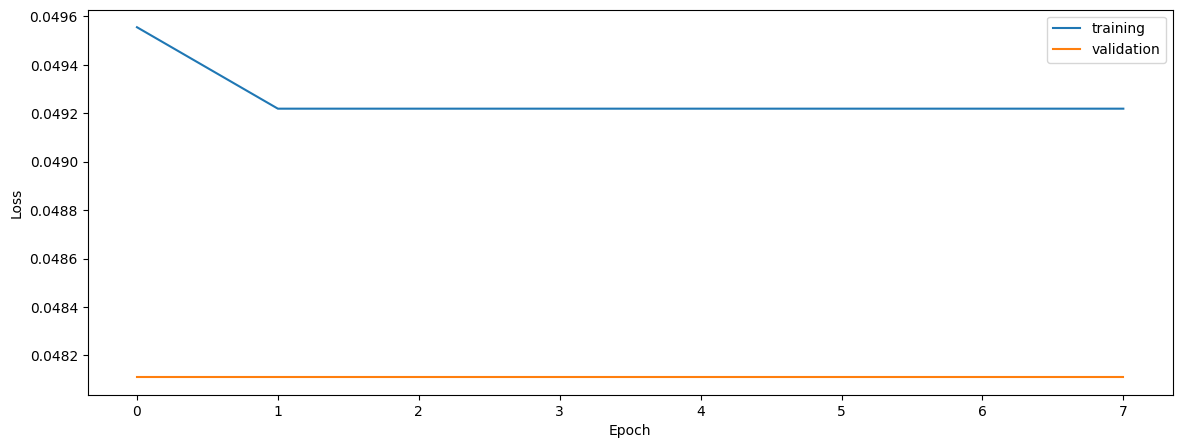

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.07683047782330435
0.0559720350788818
0.07804234073953756


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.07683047782330435
0.0559720350788818
0.07804234073953756


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.08239680775354973
0.0817445526335697
0.07568917600317097


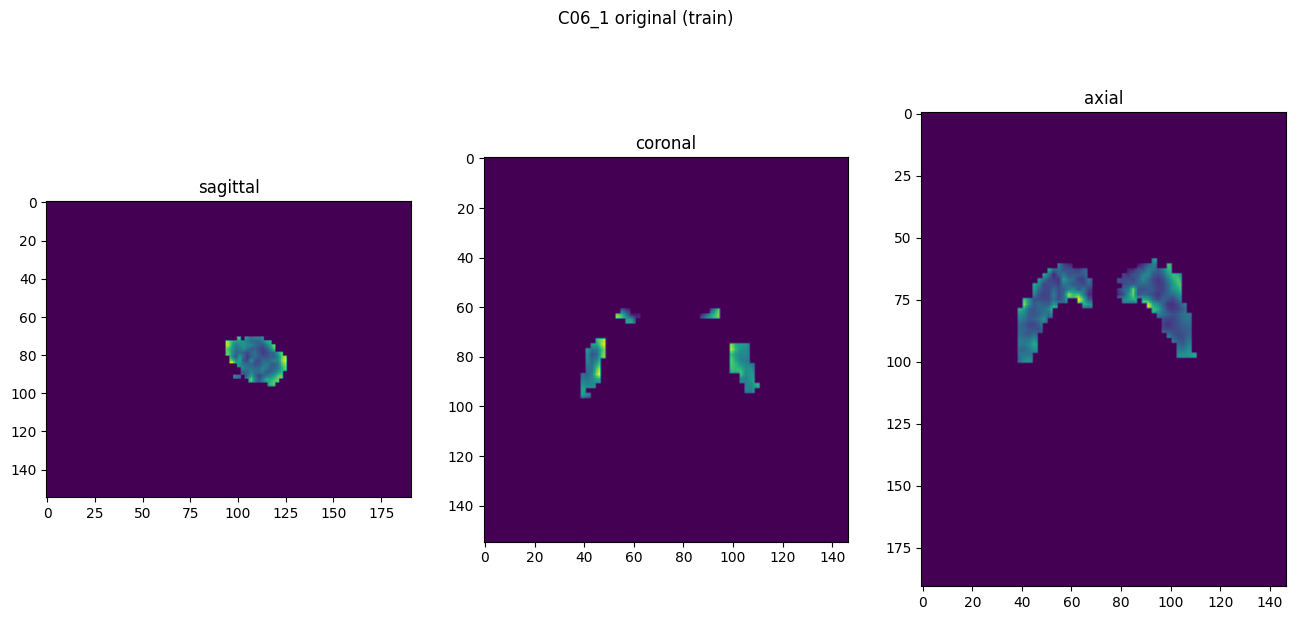

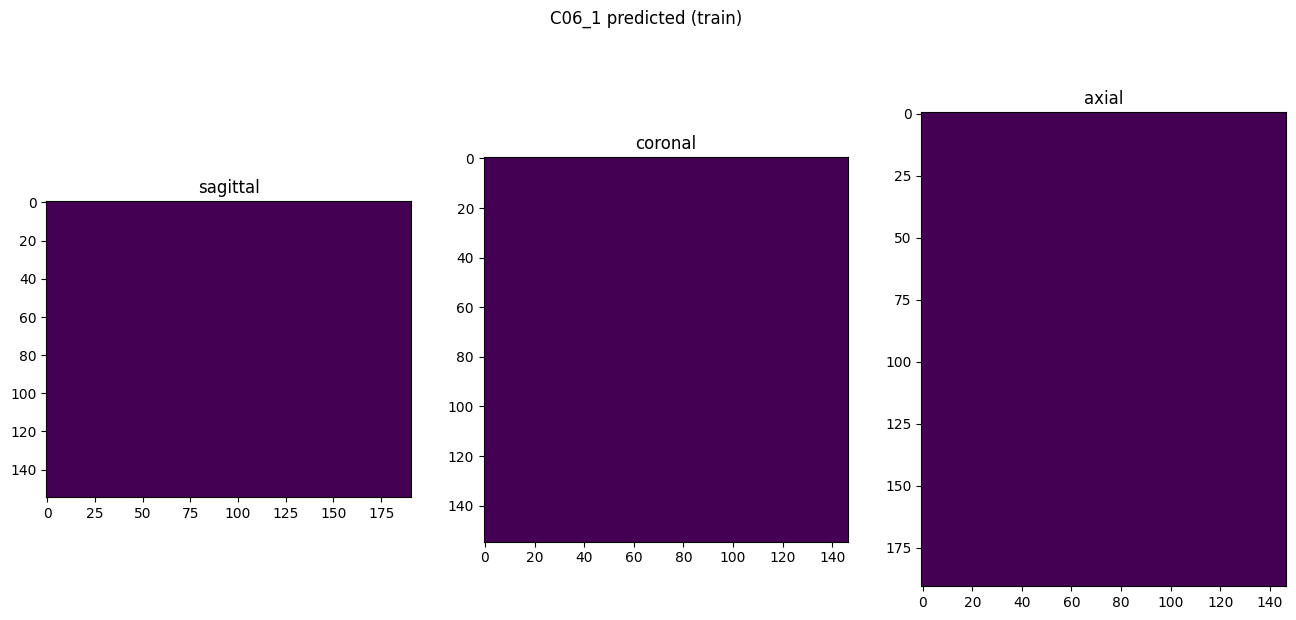

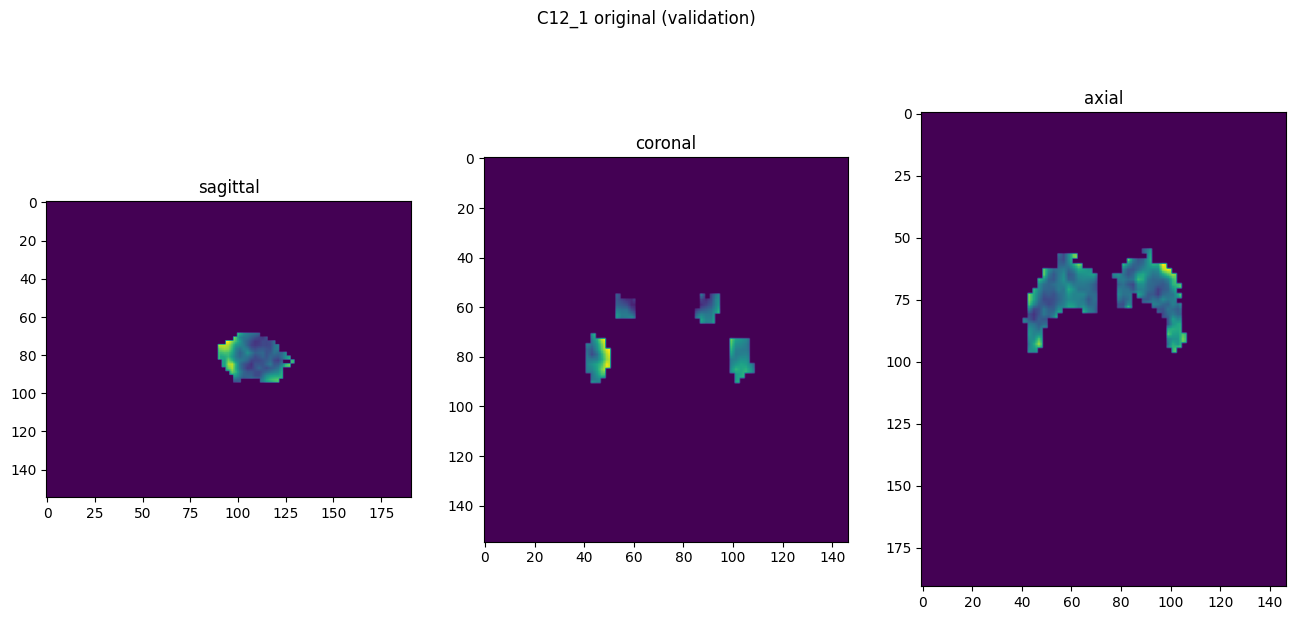

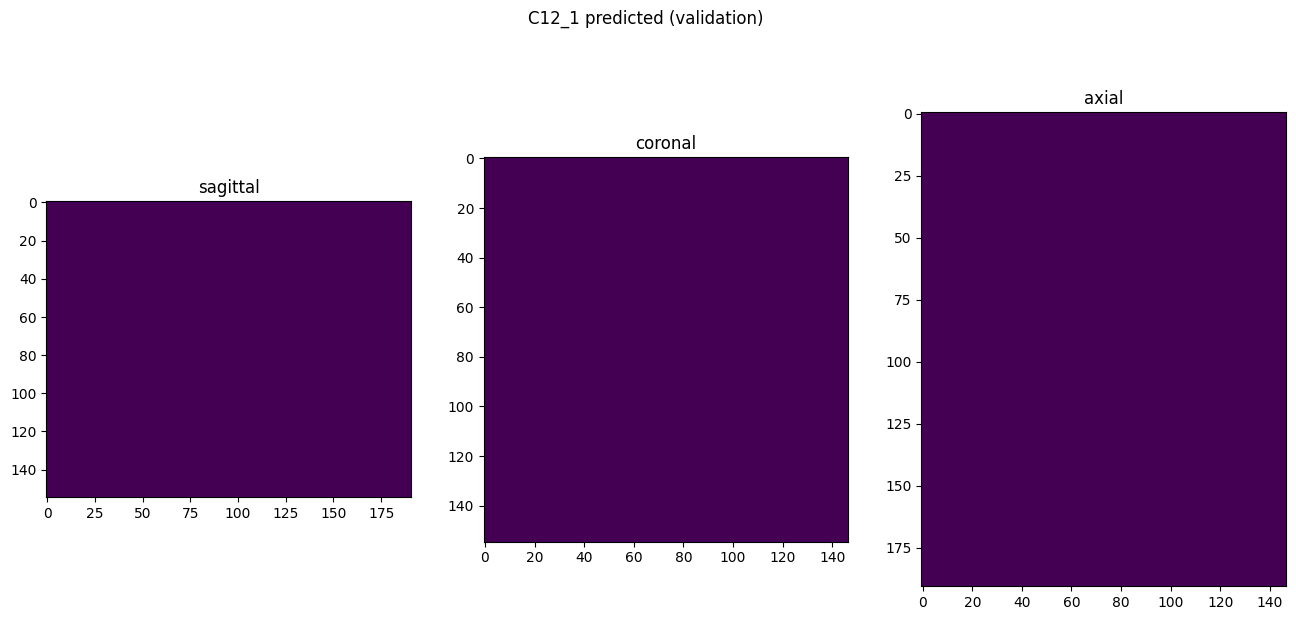

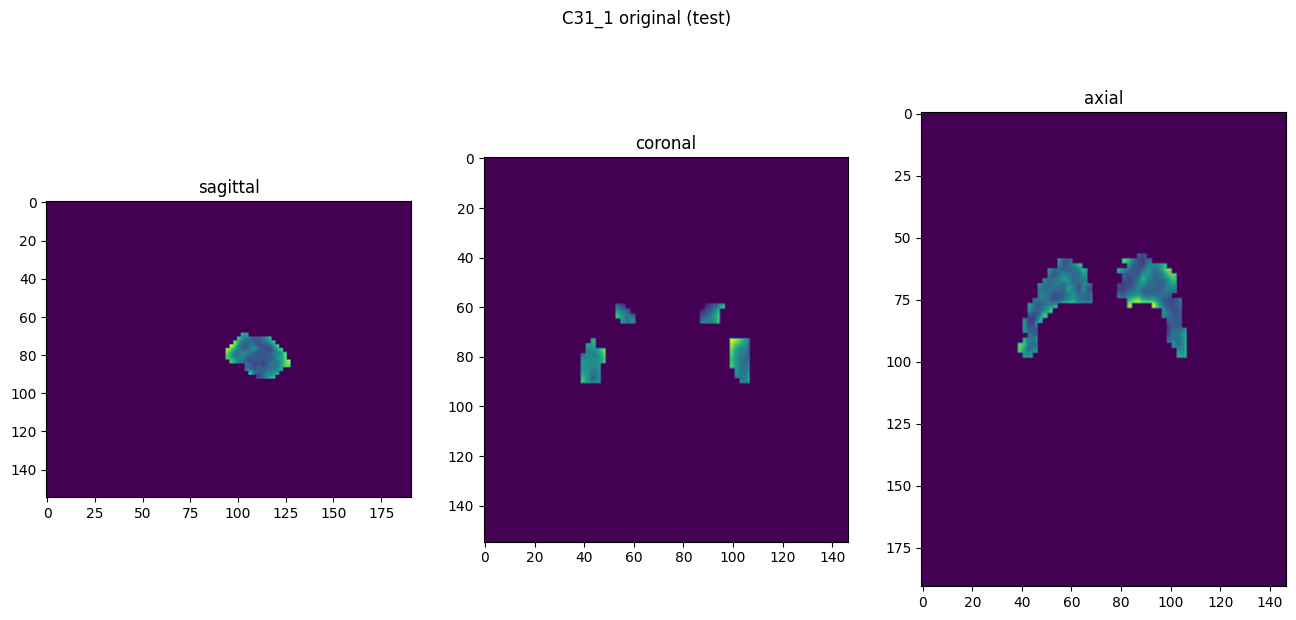

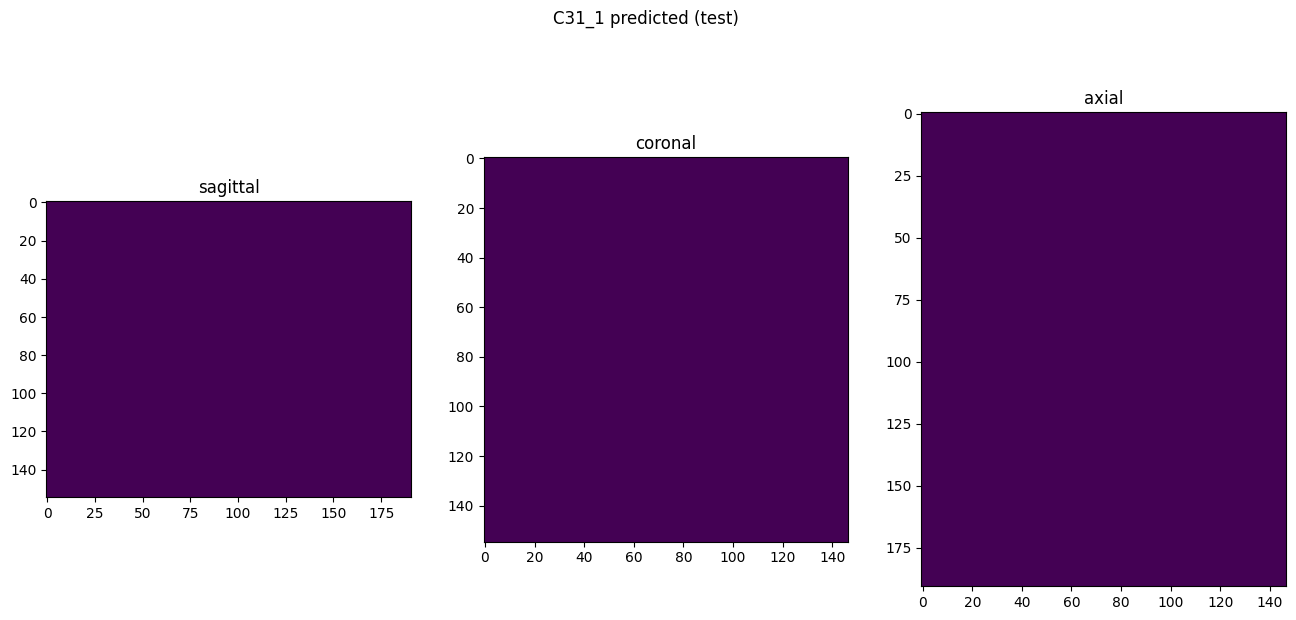

In [10]:
showResults(model, gen, threshold=None, background=False)